In [3]:
import pandas as pd
df = pd.read_csv('/Users/emilianopenaloza/Git/TwitterControl/DyGLib/processed_data/CanParl/ml_CanParl.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/emilianopenaloza/Git/TwitterControl/DyGLib/processed_data/CanParl/ml_CanParl.csv'

## Generate Synthetic


In [6]:
import networkx as nx
import numpy as np
from statistics import mean 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")



In [16]:
class BLock_model():
    def __init__(self,n_nodes, n_communities, cov_dictionary , means_dictionary , num_feats) -> None:

        self.arr = np.zeros((n_nodes,num_feats))
        self.n_nodes = n_nodes
        self.nodes_per_community = int(np.floor(n_nodes/ n_communities))
        cur_nodes = 0
        for c in range(n_communities):
            x= np.random.multivariate_normal(means_dictionary[c], cov_dictionary[c], self.nodes_per_community )

            self.arr[cur_nodes:cur_nodes + self.nodes_per_community,:] = x
            cur_nodes += self.nodes_per_community

        self.labels = {i: (lambda x: 0 if x> self.nodes_per_community  else 1)(i) for i in range(n_nodes)}
        self.colors = {i: (lambda x: 'red' if x> self.nodes_per_community  else 'blue')(i) for i in range(self.n_nodes)}
        self.G =nx.Graph()
        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')

    
    def get_distances(self):
        distances = np.zeros((self.arr.shape[0],self.arr.shape[0]))
        for i in range(self.arr.shape[0]): 
            for j in range(self.arr.shape[0]):
                u = self.arr[i,: ]
                v = self.arr[j,:]
                distance = np.linalg.norm(u - v)
                distances[i,j] = distance
        return (distances - np.min(distances))/(np.max(distances) - np.min(distances))
            
            


    def generate_Graph(self,thresh = .1 , inter_community_p =  .9 , outer_community_p = .4, close_features_p= .3):
        G= nx.Graph()
        distances = self.get_distances()
        def add_edge(i,j): 
            self.G.add_edge(i,j) 
            self.G.add_edge(j,i)
        for i in range(self.arr.shape[0]): 
            for j in range(self.arr.shape[0]):
                if i ==j:
                    continue
                distance = distances[i,j]
                r = np.random.uniform(0,1)
                if distance < thresh: # if the covariates are close it influences the probability of forming an edge
                    if self.labels[i] != self.labels[j]: # not in same community
                        if outer_community_p>r :
                            add_edge(i,j)
                    else: # in the same community
                        if  inter_community_p > r: 
                            add_edge(i,j)
                else:  # if covariates are further apart this decreases the probability of not forming an edge

                    if   close_features_p > r :
                        add_edge(i,j)
                 

        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')


    def set_node_features(self):
        nx.set_node_attributes(self.G, dict(zip(self.G.nodes(), self.arr)), 'features')
        nx.set_node_attributes(self.G, {i: (lambda x: 'red' if x> self.nodes_per_community else 'blue')(i) for i in range(self.n_nodes)}, 'color')
        nx.set_node_attributes(self.G, {i: (lambda x: 0 if x> self.nodes_per_community else 1)(i) for i in range(self.n_nodes)}, 'label')
        

    def get_edges_and_attributes(self,ts):
        edge_list = nx.to_pandas_edgelist(self.G)
        attr = pd.DataFrame.from_dict(dict(self.G.nodes(data=True)), orient='index')

        for j in range(attr.iloc[:,0].shape[0]):
            # print(f"==>> {attr.iloc[:,j]=} \n {attr=}")
            attr[f'x{j}'] = pd.Series([x[0] for x in attr.iloc[:,0]])

        attr = attr.drop(columns = ['features'])
        edge_list['ts'] = pd.Series([ts for k in range(len(edge_list))])
        
        return edge_list,attr[['x1','x2']].to_numpy()
    
    def draw(self):
        nx.draw(self.G, pos = nx.spring_layout(self.G), with_labels=True, node_color = [x for x in self.colors.values()])
        plt.show()

    def hist(self,ax,ts = None):
        # compute the degree distribution

        degree_sequence = sorted([d for n, d in self.G.degree()], reverse=True)
        # print(f"==>> {degree_sequence=}")
        degree_counts = nx.degree_histogram(self.G)

        # plot the histogram
        # ax.bar(range(len(degree_counts)), degree_counts)
        ax.hist(degree_sequence)
        # ax.set_xlim(np.min(degree_counts))

        # ax.xlabel('Degree')
        # ax.ylabel('Count')
        ax.set_title(f'Average Degree = {np.mean(degree_sequence): .2f} with the minium degree = {np.min(degree_sequence)} at ts={ts }')
        # print(f"==>> {np.mean(degree_counts)=}")
        # print(f"==>> {degree_counts=}")

                


# mean = [-5, -10]
# cov = [[1, .5], [.5, 2]]


# mean2 = [5, 10]
# cov2 = [[1, 3], [3, 7]]
 
mean = [1]
cov = [[0]]
mean2 = [0]
cov2 = [[0]]
 
means = [mean, mean2]
covs = [cov,cov2]

means_dictionary = {i:x for i,x in enumerate(means)}
cov_dictionary = {i:x for i,x in enumerate(covs)}

block = BLock_model(10,2 ,cov_dictionary,means_dictionary, 1)

block.generate_Graph()
# block.get_edges_and_attributes(0)

In [15]:
import random

def modify_edges(G, p1= .8, p2 = .4, p3 = .6 ,p4 = .2,threshold=.1,num_nodes = 100,means =[[3,1],[-3,-3]], covs=[[[3, 0], [0, 2]], [[3, 0], [0, 2]]] ):

    means_dictionary = {i:x for i,x in enumerate(means)}
    cov_dictionary = {i:x for i,x in enumerate(covs)}
    new_block = BLock_model(num_nodes,2 ,cov_dictionary,means_dictionary, 2)

    new_distnaces = new_block.get_distances()
    # print(new_distnaces.shape)
    # plt.hist(new_distnaces.flatten()[:100])
    # raise Exception
    for u in G.nodes():
        for v in G.nodes():
            if u == v:
                continue
            # print(u)
            # Check if u and v are in the same community
            if G.has_edge(u, v) and G.nodes[u]['label'] == G.nodes[v]['label']:
                # Move forward edges with probability p1
                if random.random() < p1:
                    new_block.G.add_edge(u, v) 
                
            elif G.has_edge(u, v):
                # Move forward edges with probability p2
                if random.random() < p2:
                    new_block.G.add_edge(u, v)
                
            # Check if u and v do not have an edge and their current feature is below a certain value
            if not G.has_edge(u, v) and new_distnaces[u,v] < threshold :
                if G.nodes[u]['label'] == G.nodes[v]['label']:
                    if random.random() < p3:
                        new_block.G.add_edge(u, v)
                else:
                    if random.random() < p4:
                        new_block.G.add_edge(u, v)

    return new_block
new_block = modify_edges(block.G)

{0: [5, 1], 1: [-5, -1]}


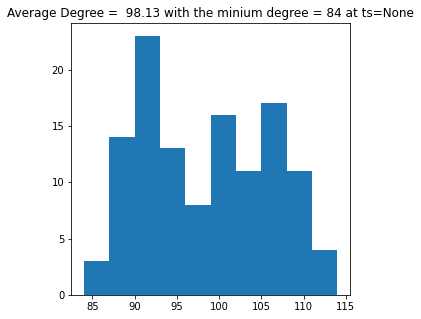

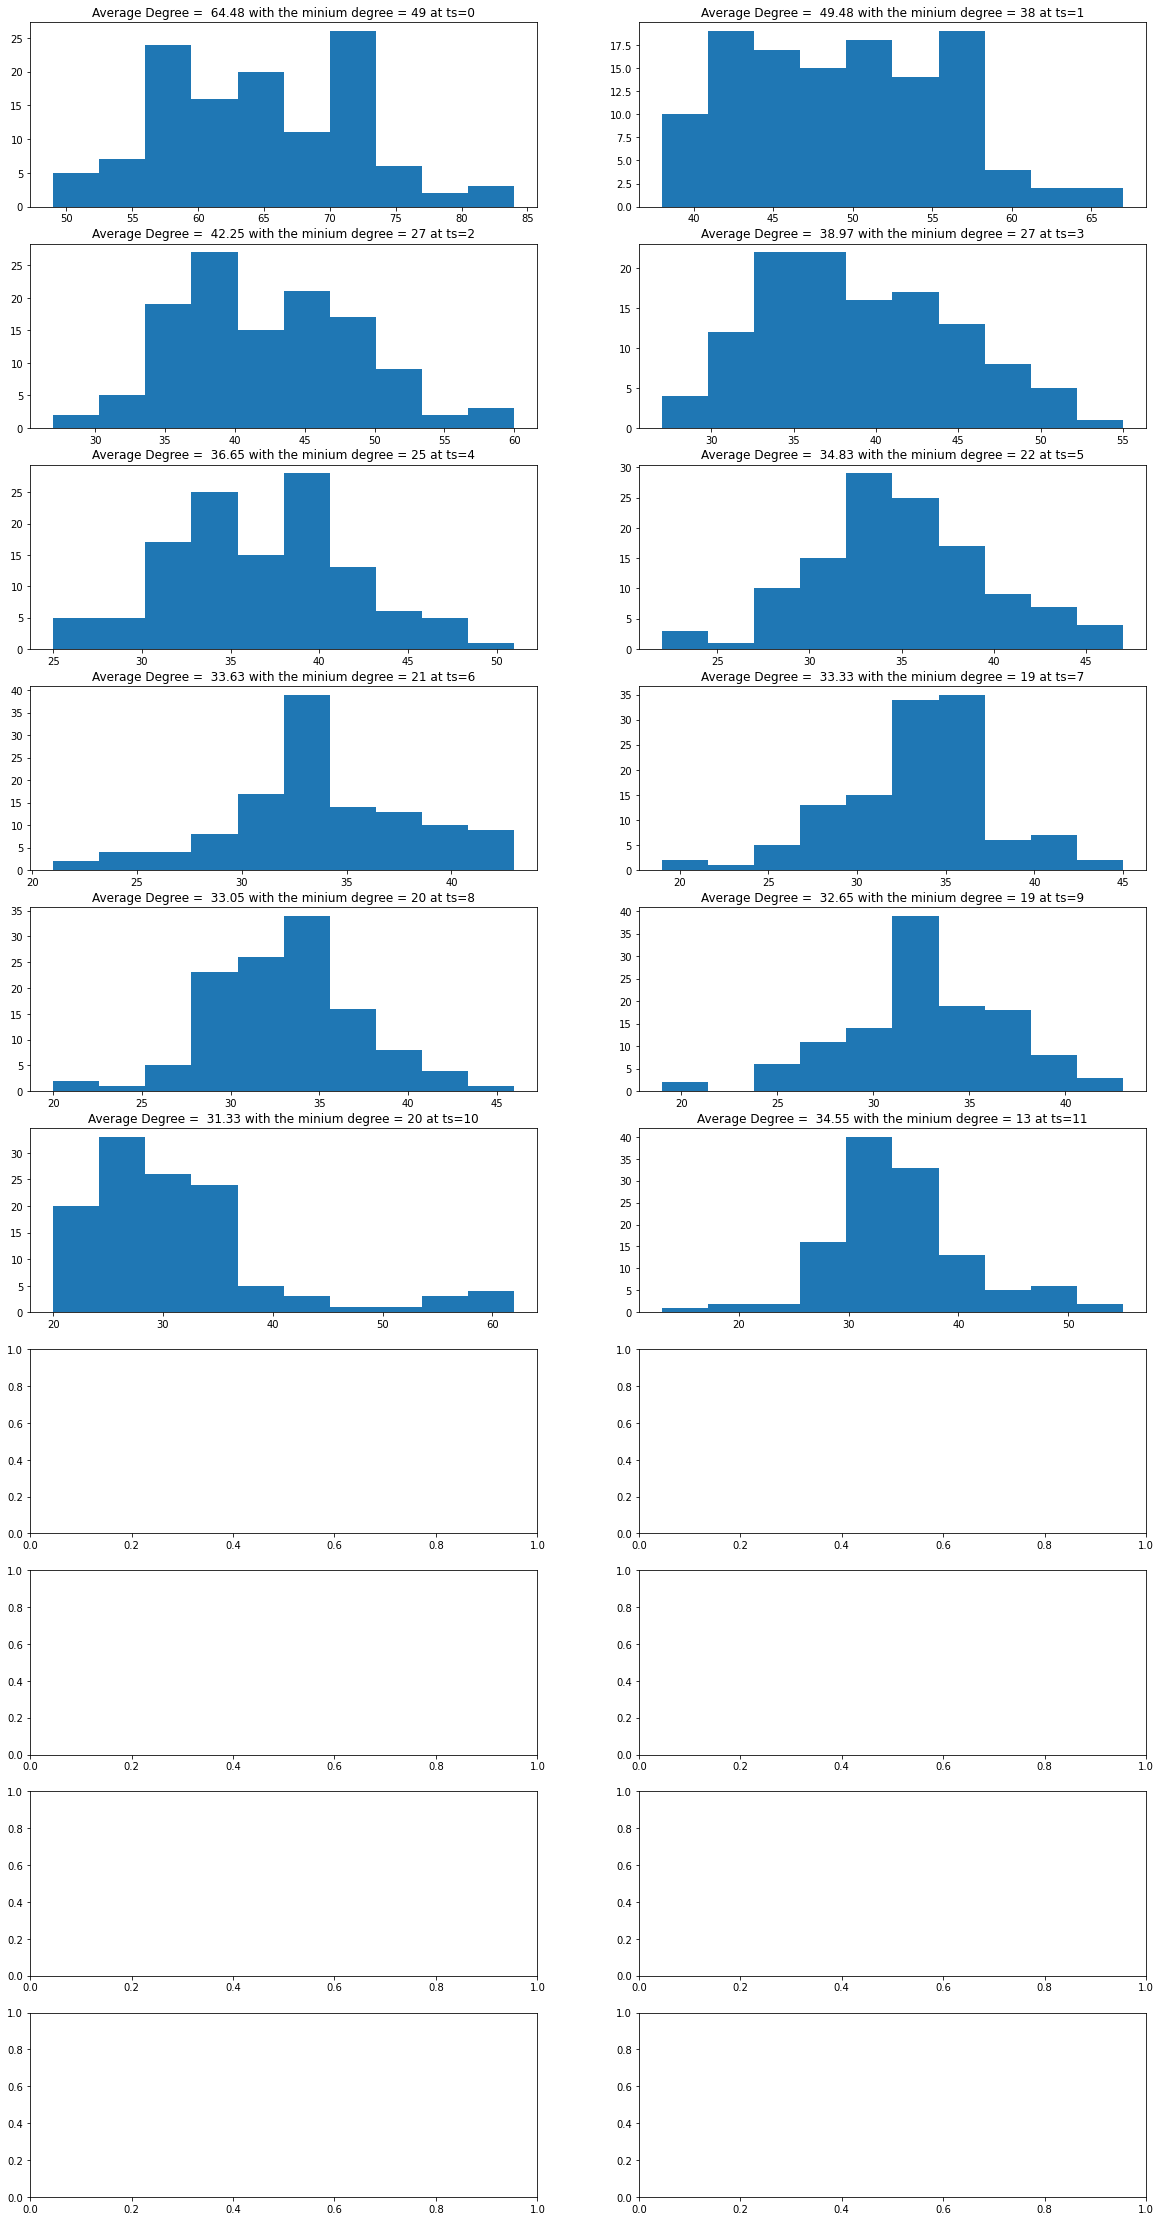

In [38]:
import pandas as pd
mean = [5, 1]
cov = [[3, 0], [0, 2]]
mean2 = [-5, -1]
cov2 = [[3, 0], [0, 2]]
# mean2 = [0, 4]
# cov2 = [[1, 0], [0, 1]]

means = [mean, mean2]
covs = [cov,cov2]

# new_mean = [1, 0]
# new_cov = [[2, 0], [0, 1]]
# new_mean2 = [-1, 0]
# new_cov2 = [[2, 0], [0, 1]]
new_mean = [5, 1]
new_cov = [[3, 0], [0, 2]]
new_mean2 = [-5, -1]
new_cov2 = [[3, 0], [0, 2]]
# mean2 = [0, 4]
# cov2 = [[1, 0], [0, 1]]

means2 = [new_mean, new_mean2]
covs2 = [new_cov,new_cov2]

means_dictionary = {i:x for i,x in enumerate(means)}
cov_dictionary = {i:x for i,x in enumerate(covs)}
print(means_dictionary)

edges_all = pd.DataFrame()
attr_all = []
num_nodes = 120
base_block = BLock_model(num_nodes,2 ,cov_dictionary,means_dictionary, 2)
base_block.generate_Graph(thresh = .1 , inter_community_p =  .7 , outer_community_p = .05, close_features_p= .75)
fig,ax = plt.subplots(1,1 , figsize = (5,5))
base_block.hist(ax)
plt.show()
prev_edges,previous = base_block.get_edges_and_attributes(0)
edge_lists = []
graphs = runs = 20
runs = 12
fig,ax = plt.subplots(int(graphs/2),2 , figsize = (20,40))

for i in range(graphs ):
    if i == runs:
        break


    new_block =  modify_edges(base_block.G,num_nodes = num_nodes,p1= .75 if i < graphs/2 else 0 ,p2 = .25 if i < graphs/2 else 0\
                              , p3 = .1 if i < graphs/2 else .95, p4 = .05 if i < graphs/2 else .95 ,threshold=.1 if i < graphs/2 else .4,\
                                  means = means if i < graphs/2 else means2 , covs = covs if i < graphs/2 else covs2)
    new_block.set_node_features()
    edges,attr = new_block.get_edges_and_attributes(i)
    new_block.hist(ax = ax.flatten()[i], ts = i )
    
    previous = attr
    prev_edges = edges

    edge_lists.append(edges)
    if i == 0 :
        attr_all = attr
    else:
        attr_all = np.vstack([attr_all,attr])
    base_block = new_block
edges_all = pd.concat(edge_lists,axis = 0)
# print(attr_all.shape)
attr_all = attr_all.reshape((runs,num_nodes,2))

base = '/home/emiliano/projects/def-cbravo/emiliano/DyGLib/processed_data/Synthetic/'
edges_all= edges_all.rename(columns = {'source': 'u','target':'i'})
edges_all['idx'] = pd.Series([ x for x in range(len(edges_all))])
edges_all['label'] = pd.Series([ 0 for x in range(len(edges_all))])

edges_all.to_csv(f'{base}/ml_Synthetic.csv',index=False)
np.save(f'{base}/ml_Synthetic_node.npy',attr_all)
edge_attr = np.ones(len(edges_all)).reshape(-1,1)
np.save(f'{base}/ml_Synthetic.npy',edge_attr)

## Embedding Generation Block

In [8]:
import pickle as pkl
def genetare_dict():
    return defaultdict(list)
with open('/home/emiliano/projects/def-cbravo/emiliano/DyGLib/embedding_file.pkl' , 'rb') as f :

    embedding_dict = pkl.load(f)

In [9]:
import numpy as np
num_feats = embedding_dict[0][0][0].shape[0]
embeddings = np.zeros((len(embedding_dict.keys()),120, num_feats))

In [10]:
for ts in embedding_dict.keys():
    for u in embedding_dict[ts].keys():
        try:
            embeddings[ts,u,:] = embedding_dict[ts][u][0]
        except Exception as e:
            print(embedding_dict[ts][u][0])
            raise Exception


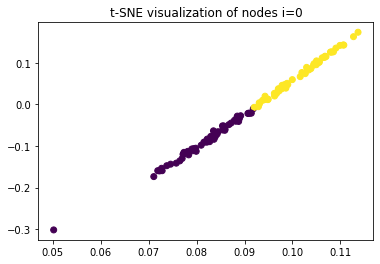

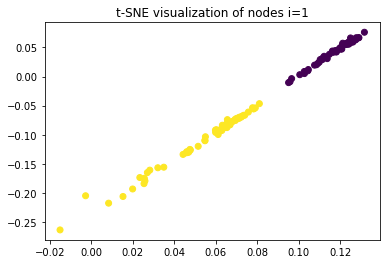

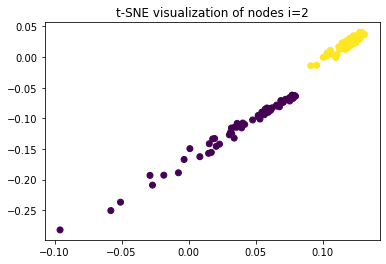

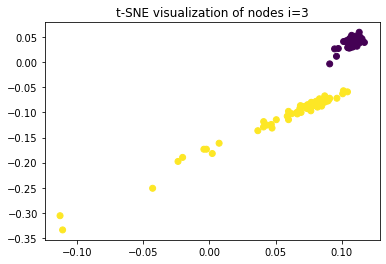

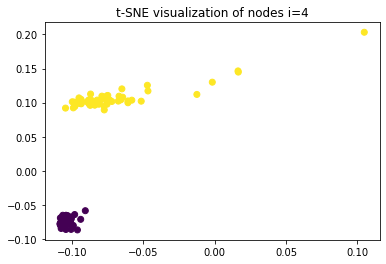

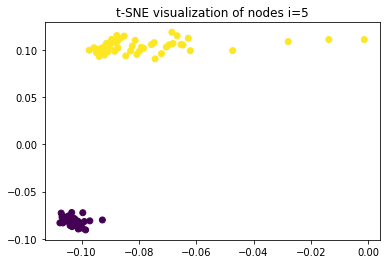

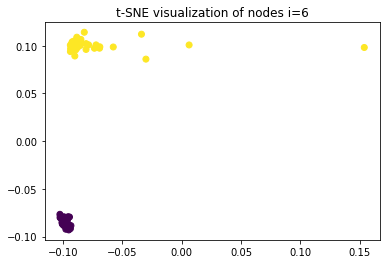

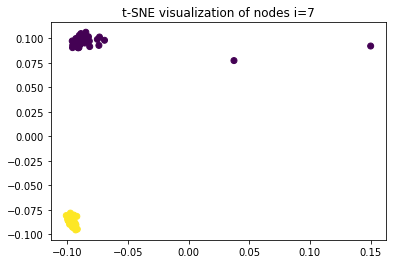

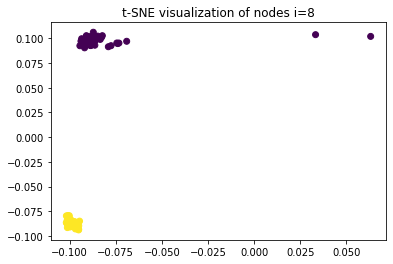

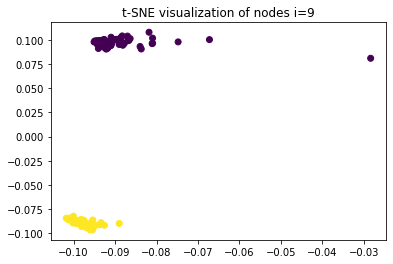

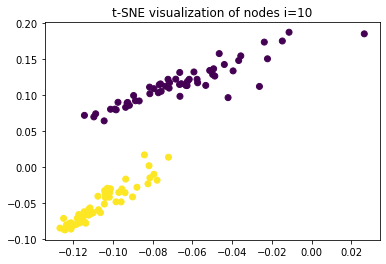

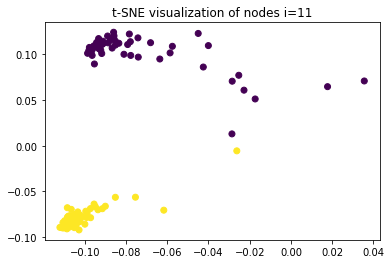

In [14]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
for i in range(embeddings.shape[0]):
    # Generate some example data
    nodes = embeddings[i,:,:]  # 100 nodes with 10 features each
    # Create a mask where the rows are all equal to the value
    mask = np.all(nodes == 0, axis=1)

# Use the mask to exclude the rows
    nodes = nodes[~mask]

    # Create a t-SNE object and fit the data
    # tsne = TSNE(n_components=2)
    U, S, V = np.linalg.svd(nodes)
    nodes_tsne = U[:,:2]
    # nodes_tsne = tsne.fit_transform(nodes)

    # Apply k-means clustering with k=3
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(nodes_tsne)
    cluster_labels = kmeans.labels_

    # Visualize the data, colored by cluster labels
    plt.scatter(nodes_tsne[:, 0], nodes_tsne[:, 1], c=cluster_labels)
    plt.title(f"t-SNE visualization of nodes {i=}")
    plt.show()
